In [864]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [865]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'forward learning rate':0.01,
        'inverse learning rate':0.01,

        'forward training epochs':1000,
        'inverse training epochs':1000,

        'forward training criterion':nn.L1Loss(),
        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [866]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [867]:
df = pd.read_excel('wide_range.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [868]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,2.999482e-14,4.442183e-14,3.656011e-14,5.194757e-14,4.973315e-14,7.323828e-14,5.203014e-14,7.218750e-14,8.672268e-14,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,2.303472e-14,2.137935e-14,3.026088e-14,2.454882e-14,3.471853e-14,3.357273e-14,5.103051e-14,3.893226e-14,5.676652e-14,7.142763e-14,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,3.321009e-14,2.824623e-14,3.587004e-14,2.765798e-14,3.802290e-14,3.688717e-14,5.919539e-14,5.122215e-14,8.020764e-14,1.073738e-13,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,1.357453e-14,1.187304e-14,1.558260e-14,1.228372e-14,1.717658e-14,1.683286e-14,2.695498e-14,2.296024e-14,3.580425e-14,4.786284e-14,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,2.619885e-14,2.332198e-14,3.140154e-14,2.493494e-14,3.488262e-14,3.382589e-14,5.274100e-14,4.275298e-14,6.464003e-14,8.408254e-14,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,3.291908e-14,2.904236e-14,3.868747e-14,3.052280e-14,4.249031e-14,4.114082e-14,6.427529e-14,5.247101e-14,7.966764e-14,1.038464e-13,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,2.234104e-14,1.882600e-14,2.361172e-14,1.812234e-14,2.488261e-14,2.422053e-14,3.928364e-14,3.469407e-14,5.502010e-14,7.455935e-14,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,2.847468e-14,2.408754e-14,3.030068e-14,2.326424e-14,3.189002e-14,3.105177e-14,5.022622e-14,4.412174e-14,6.973943e-14,9.391391e-14,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,1.648649e-14,1.406005e-14,1.783686e-14,1.379136e-14,1.903271e-14,1.863127e-14,3.027923e-14,2.667106e-14,4.232606e-14,5.720658e-14,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [869]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [870]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [871]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

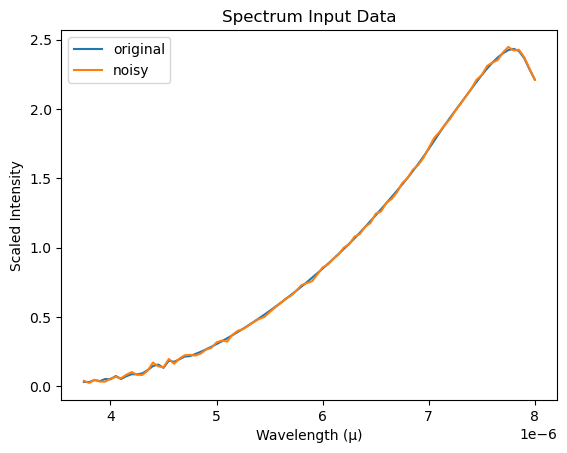

In [872]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [873]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)
spec_unscaled = scaler.inverse_transform(spec_scaled)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [874]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [875]:
spec_unscaled

array([[0.03105584, 0.02999482, 0.04442183, ..., 2.36597201, 2.28558255,
        2.21152006],
       [0.02303472, 0.02137935, 0.03026088, ..., 1.71166774, 1.65682389,
        1.60630741],
       [0.03321009, 0.02824623, 0.03587004, ..., 4.49959521, 4.32960797,
        4.17304151],
       ...,
       [0.02847468, 0.02408754, 0.03030068, ..., 2.56521541, 2.47682096,
        2.39538243],
       [0.01648649, 0.01406005, 0.01783686, ..., 1.20163893, 1.16569548,
        1.13260748],
       [0.02009135, 0.01711356, 0.02174333, ..., 4.45698039, 4.28885161,
        4.13399539]])

In [876]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.892038,0.062310,0.900311,0.589139,-0.124517,1.239399,0.650550,0.852685,0.873724,0.778428,...,-0.297920,-0.307448,-0.318301,-0.298810,-0.285839,-0.309201,-0.292961,-0.292733,-0.292847,-0.297428
1,0.374922,0.291705,0.614919,-1.026213,0.381103,0.670421,-0.782078,-0.365904,-0.482380,0.057800,...,-0.806374,-0.791630,-0.785913,-0.786825,-0.790762,-0.786917,-0.787699,-0.783380,-0.774716,-0.788088
2,0.206303,0.562865,0.415484,-1.390144,-0.473048,0.378875,-0.149778,1.996995,0.318360,0.597203,...,1.315610,1.309760,1.320865,1.314024,1.308346,1.314003,1.313601,1.320141,1.310088,1.321105
3,-0.209680,-1.079985,0.185799,-0.694308,-1.182502,-1.471309,-1.147434,-0.592184,-1.349926,-1.112906,...,0.035296,0.045081,0.049382,0.049653,0.041612,0.037922,0.039627,0.061752,0.034482,0.049592
4,-0.119203,-0.412515,-0.294832,-0.126222,0.117599,1.445090,-0.557267,0.402410,-0.113367,0.786626,...,0.302275,0.301121,0.308752,0.299218,0.315516,0.319671,0.307880,0.316881,0.308614,0.317337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.535658,0.136186,1.211527,-0.282570,0.095687,0.037911,0.561040,-0.062955,0.673905,0.820908,...,0.590608,0.574888,0.578468,0.569036,0.579936,0.587741,0.580890,0.570831,0.578778,0.581793
2196,-0.416768,-0.416580,-0.473799,-0.353931,-1.533651,-0.973479,-0.470801,-0.172993,-0.159924,-0.552964,...,1.621209,1.599649,1.603641,1.605284,1.603377,1.602625,1.600521,1.590989,1.593190,1.588943
2197,0.218140,-0.166447,-0.047629,1.361715,-0.050181,0.328770,-0.187966,-0.623691,0.022337,0.449249,...,-0.144140,-0.163594,-0.160341,-0.161598,-0.144867,-0.153250,-0.150954,-0.149977,-0.149222,-0.157103
2198,-0.806290,-0.579448,-0.650451,-0.544871,-1.064824,-0.713801,-1.129925,-1.408172,-0.728166,-0.583557,...,-1.168482,-1.171538,-1.168927,-1.171026,-1.170463,-1.177443,-1.177472,-1.179739,-1.184705,-1.173219


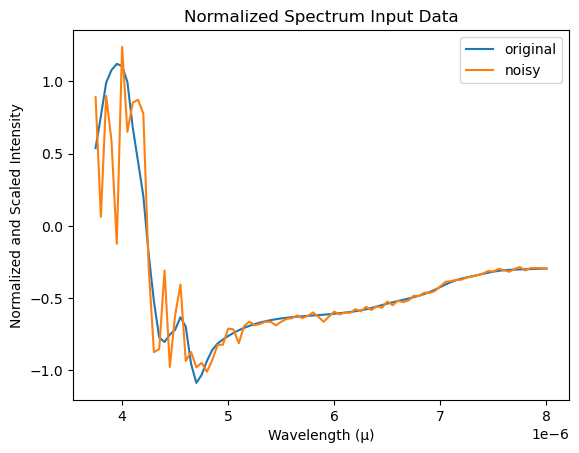

In [877]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [878]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [879]:
# Feature Selection

In [880]:
spec_train

tensor([[ 0.7771,  1.0832,  2.8331,  ...,  0.7059,  0.6982,  0.7110],
        [ 1.5507,  1.2165,  0.9185,  ..., -0.2896, -0.2862, -0.2856],
        [-1.0375, -0.2418, -0.0780,  ..., -0.6665, -0.6701, -0.6867],
        ...,
        [ 1.6677,  2.6426,  1.5101,  ...,  1.9237,  1.9234,  1.9136],
        [ 0.6276, -0.6199, -0.3256,  ..., -0.0836, -0.0971, -0.0843],
        [-1.2845, -0.6085, -1.1393,  ...,  0.5110,  0.5208,  0.5285]])

In [881]:
temp_train

tensor([[370.3413, 328.5613, 326.2462,  ..., 334.0032, 331.4733, 344.6604],
        [358.7178, 321.1420, 335.1217,  ..., 336.1974, 344.1709, 318.3873],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [370.2241, 340.5473, 330.7923,  ..., 343.7119, 361.5406, 369.9658],
        [308.7229, 320.0291, 305.8729,  ..., 333.4956, 311.0175, 324.1667],
        [338.4227, 306.0559, 297.0075,  ..., 323.1169, 302.0772, 340.2445]])

# Model Design

In [882]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [883]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [884]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [885]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)


x = torch.rand(1540, io_size)
print(forward_model(inverse_model(x)).shape)
pred_temp_x, pred_spec_x = tandem_net(x)
print(pred_spec_x.shape)

torch.Size([1540, 86])
torch.Size([1540, 86])


# Training Loop

In [886]:
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}')

    return forward_loss_list
        

In [887]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    tandem_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['inverse learning rate'])

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate loss
        pred_temp, pred_spec = tandem_net(spec_train)
        loss = criterion(spec_train, pred_spec)

        # calculate inverse loss (too see spec to temp accuracy)
        inverse_loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        inverse_loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            tandem_loss_sum += loss.item()

        tandem_loss_list.append(loss.item())
        inverse_loss_list.append(inverse_loss.item())

        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {loss}, inverse loss = {inverse_loss}')

    avg_inverse_loss = tandem_loss_sum / (num_inverse_epochs - 100)
    print(f'\nAVERAGE INVERSE LOSS: {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [888]:
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_inverse_model(tandem_net, spec_train)

FORWARD MODEL TRAINING
forward epoch: 100, forward loss = 0.3965304493904114
forward epoch: 200, forward loss = 0.3091917634010315
forward epoch: 300, forward loss = 0.22098341584205627
forward epoch: 400, forward loss = 0.21110142767429352
forward epoch: 500, forward loss = 0.2041793167591095
forward epoch: 600, forward loss = 0.20031137764453888
forward epoch: 700, forward loss = 0.19865599274635315
forward epoch: 800, forward loss = 0.19707755744457245
forward epoch: 900, forward loss = 0.19300788640975952
forward epoch: 1000, forward loss = 0.19185668230056763

AVERAGE FORWARD LOSS: 0.22391945218046505

INVERSE MODEL TRAINING
forward epoch: 100, tandem loss = 0.29655158519744873, inverse loss = 8.676093101501465
forward epoch: 200, tandem loss = 0.18283215165138245, inverse loss = 6.534826278686523
forward epoch: 300, tandem loss = 0.17604318261146545, inverse loss = 5.698102951049805
forward epoch: 400, tandem loss = 0.1694212108850479, inverse loss = 5.404699802398682
forward epo

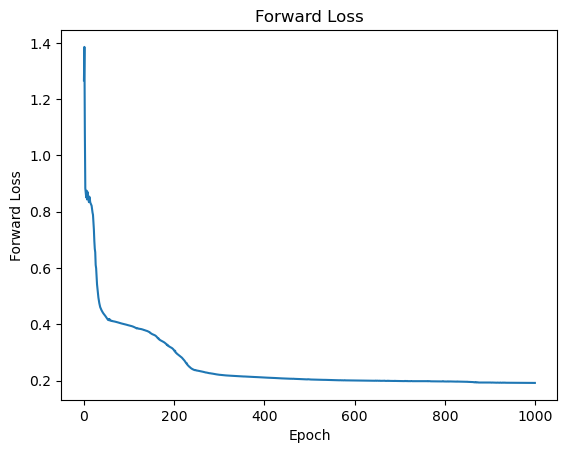

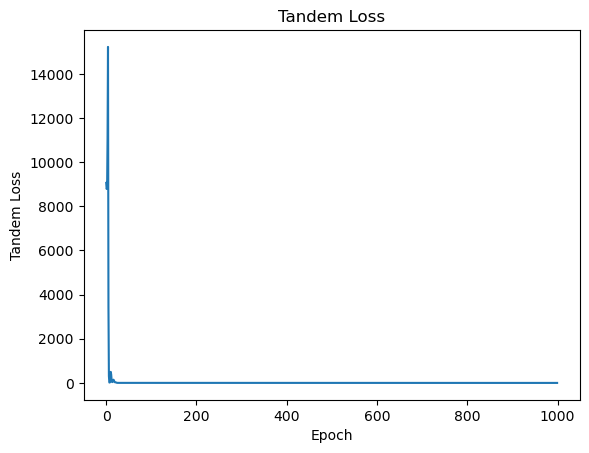

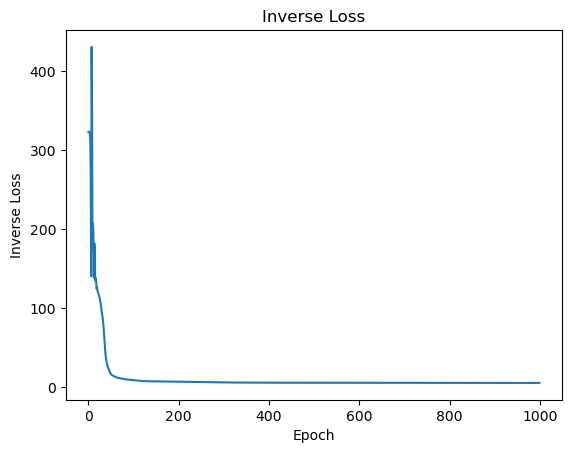

In [889]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()


# plot tandem loss
plt.plot(tandem_loss_list)

plt.title("Tandem Loss")
plt.xlabel("Epoch")
plt.ylabel("Tandem Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [890]:
pred_temp, pred_spec = tandem_net(spec_test)

In [891]:
# pred_temp = scaler.inverse_transform(pred_temp.detach().numpy())

In [892]:
pred_temp

tensor([[284.1115, 317.4124, 324.3683,  ..., 321.8155, 317.0731, 297.5698],
        [371.7507, 342.8759, 337.8901,  ..., 316.9652, 308.2854, 276.4751],
        [310.4922, 304.6346, 305.1436,  ..., 324.8381, 332.8038, 339.7220],
        ...,
        [286.4301, 305.8695, 311.0732,  ..., 324.2216, 326.5582, 292.1601],
        [302.8072, 304.7000, 309.6024,  ..., 338.1505, 344.4417, 340.3181],
        [348.2837, 329.9247, 323.7187,  ..., 326.6832, 331.1104, 304.2899]],
       grad_fn=<AddmmBackward0>)

In [893]:
pred_spec = scaler.inverse_transform(pred_spec.detach().numpy())

In [894]:
pred_spec

array([[0.01854425, 0.01616371, 0.01833398, ..., 1.6078676 , 1.5590702 ,
        1.5481086 ],
       [0.03947825, 0.0354782 , 0.04870149, ..., 1.1109718 , 1.0675648 ,
        0.99323815],
       [0.02153864, 0.01626845, 0.02292241, ..., 3.7415054 , 3.5813577 ,
        3.4510975 ],
       ...,
       [0.0159318 , 0.01372938, 0.0166729 , ..., 1.5207283 , 1.4487977 ,
        1.4552989 ],
       [0.0229685 , 0.0180976 , 0.02407507, ..., 3.662857  , 3.479041  ,
        3.3905866 ],
       [0.03091945, 0.02789993, 0.04019106, ..., 1.9342498 , 1.8420128 ,
        1.8196242 ]], dtype=float32)

In [895]:
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [896]:
spec_test

array([[0.01993628, 0.00399895, 0.02609183, ..., 1.5298477 , 1.459459  ,
        1.4309912 ],
       [0.05204775, 0.03108878, 0.06182365, ..., 0.9577427 , 0.93366987,
        0.90169233],
       [0.00721901, 0.00953611, 0.01713046, ..., 3.4553797 , 3.3223372 ,
        3.2214534 ],
       ...,
       [0.01016774, 0.01755944, 0.02780493, ..., 1.4438562 , 1.3981742 ,
        1.3571987 ],
       [0.01932232, 0.04390274, 0.02043851, ..., 3.3718965 , 3.2454047 ,
        3.1232204 ],
       [0.04052247, 0.02833511, 0.0432816 , ..., 1.8200623 , 1.7553389 ,
        1.7105849 ]], dtype=float32)

In [897]:
temp_test

tensor([[303.5462, 306.8629, 318.0060,  ..., 316.4249, 320.6739, 295.2881],
        [371.2663, 341.5596, 327.9726,  ..., 324.5002, 302.2532, 275.2513],
        [309.3946, 295.1643, 300.0339,  ..., 325.8748, 329.4067, 340.4557],
        ...,
        [308.5519, 299.2315, 315.2401,  ..., 326.2476, 322.1920, 293.0025],
        [283.5906, 310.9670, 327.0831,  ..., 332.6732, 346.8429, 338.8449],
        [346.8799, 337.7896, 315.8813,  ..., 324.8820, 326.0698, 303.8605]])

In [898]:
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

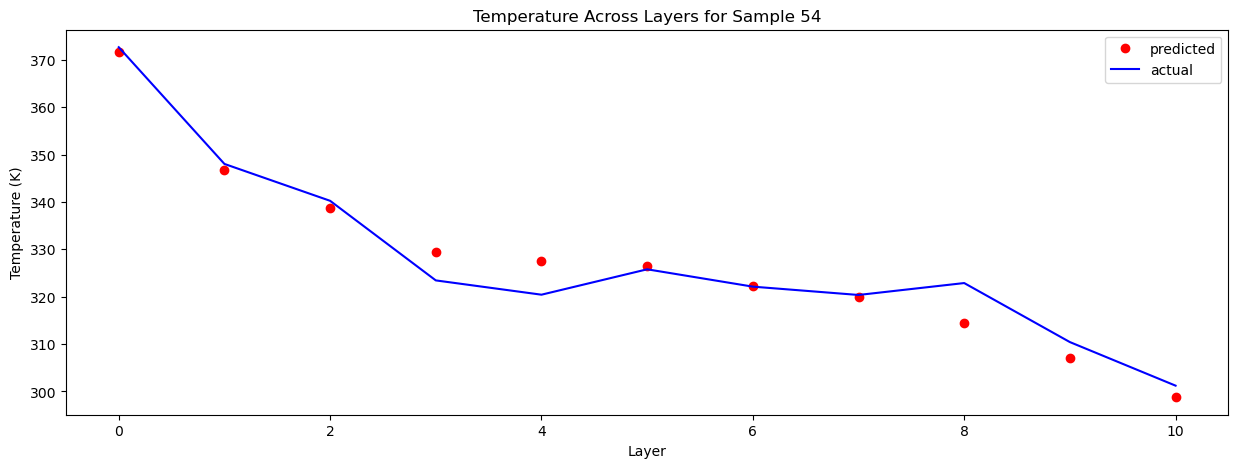

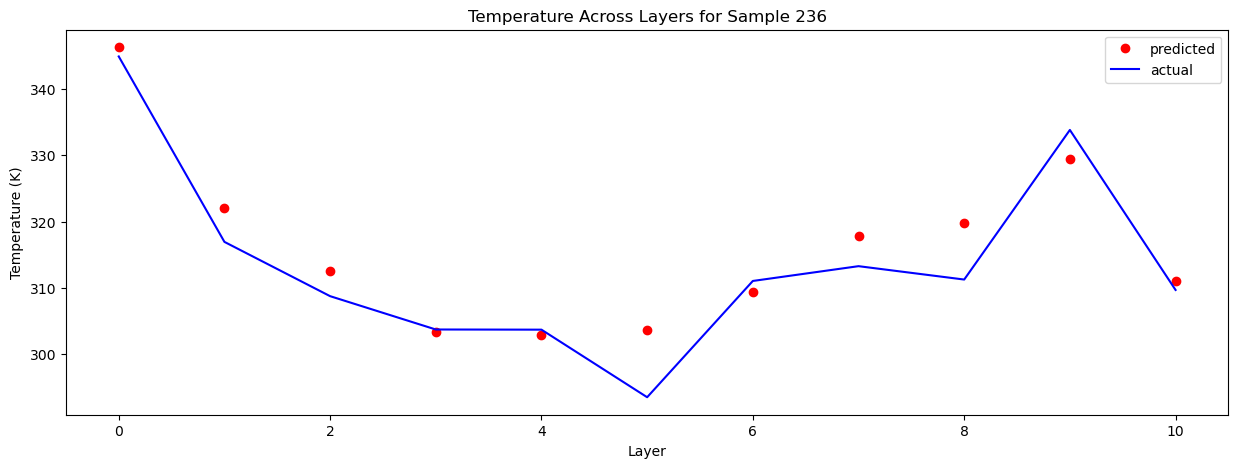

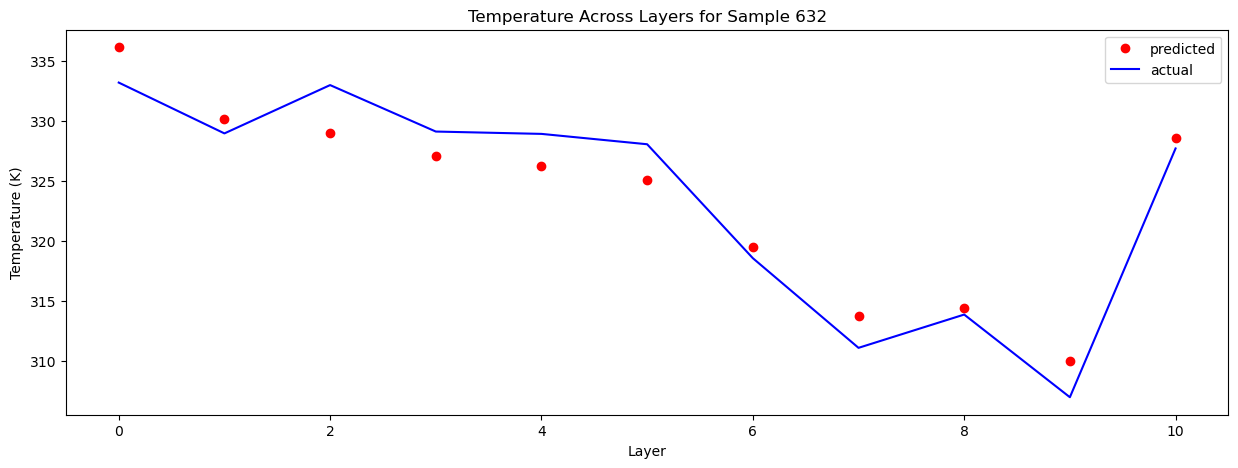

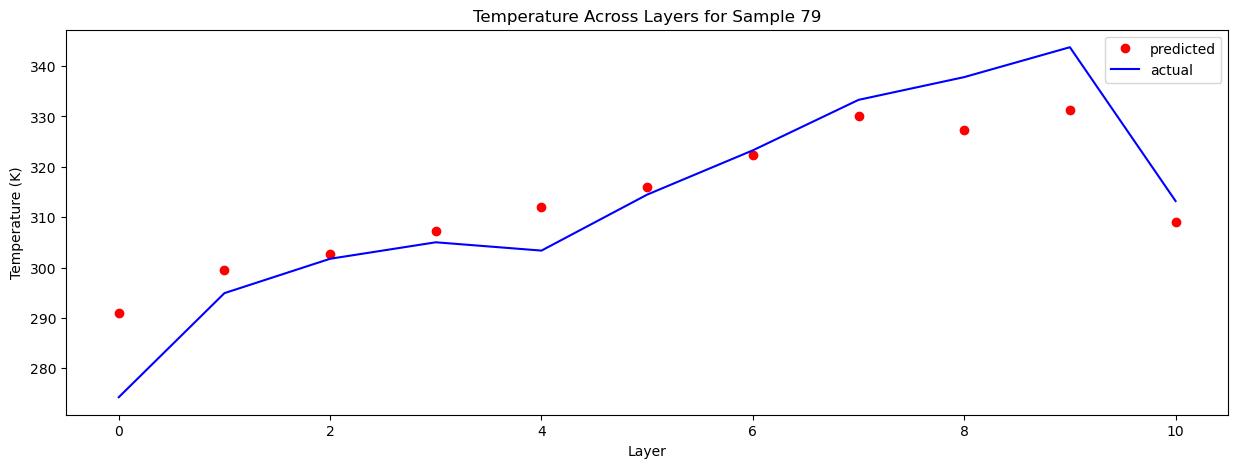

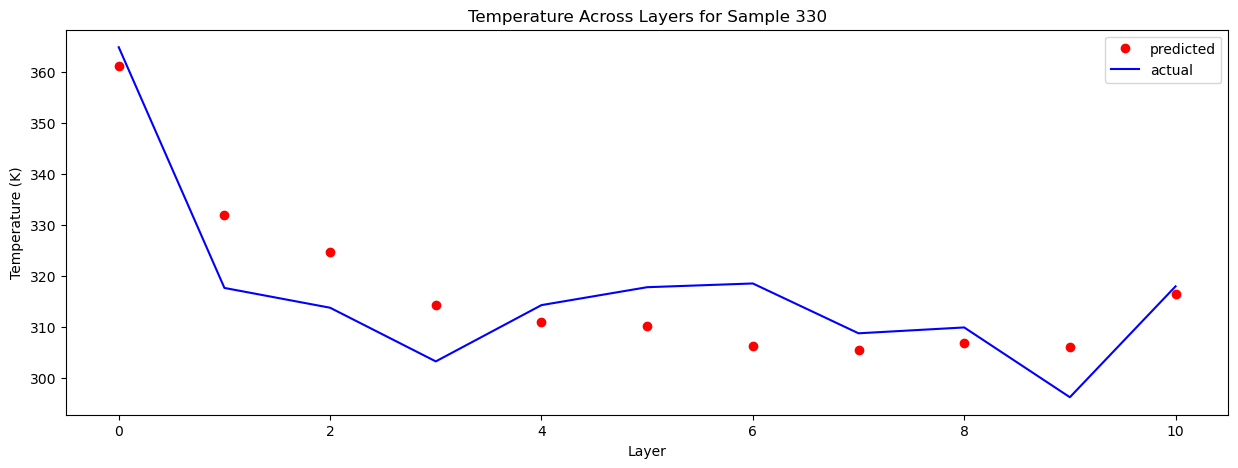

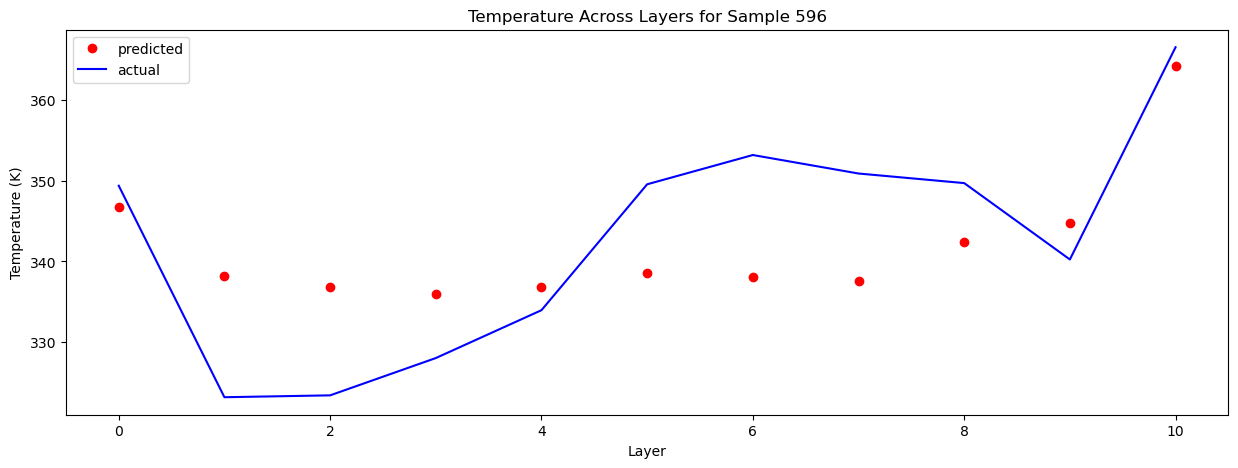

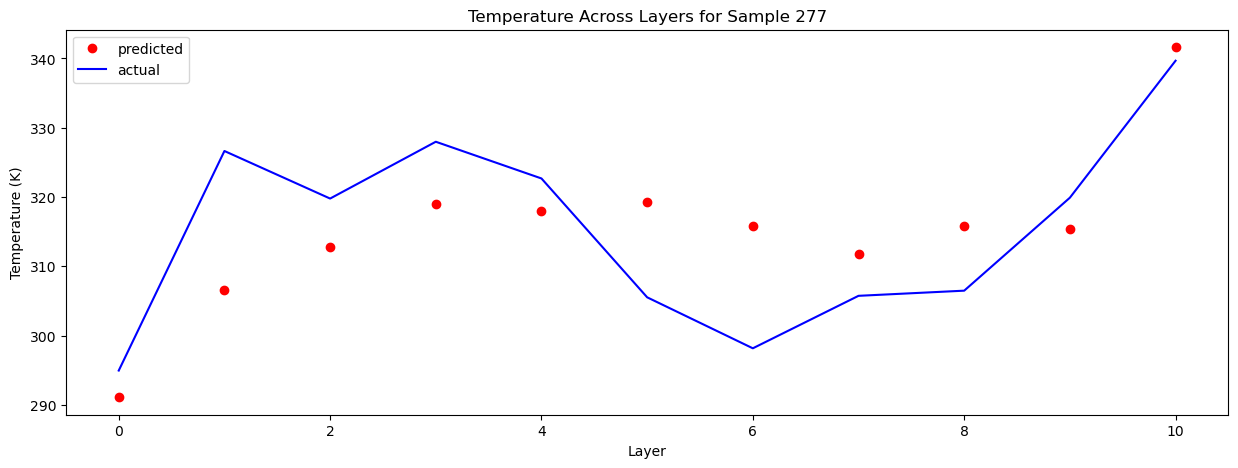

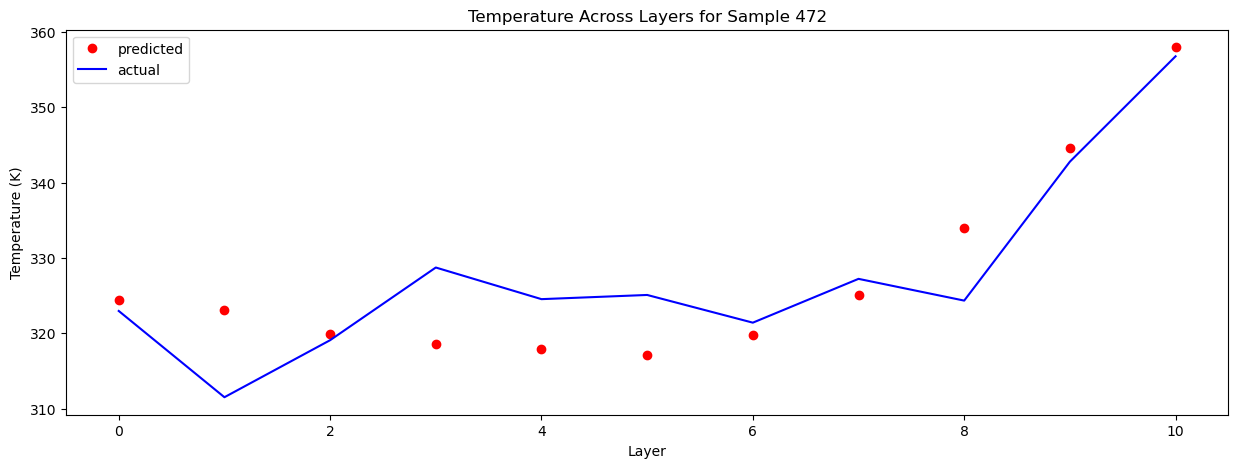

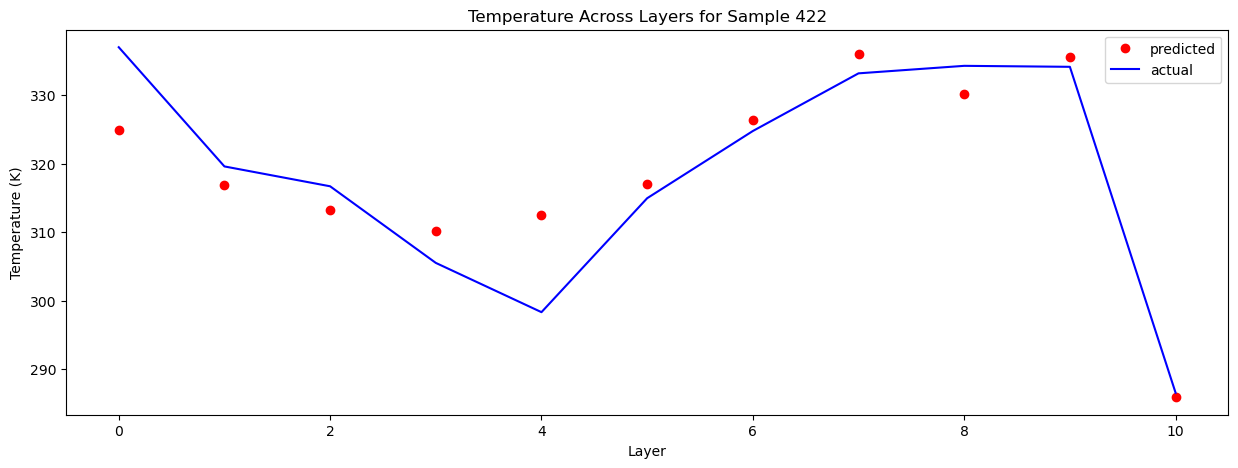

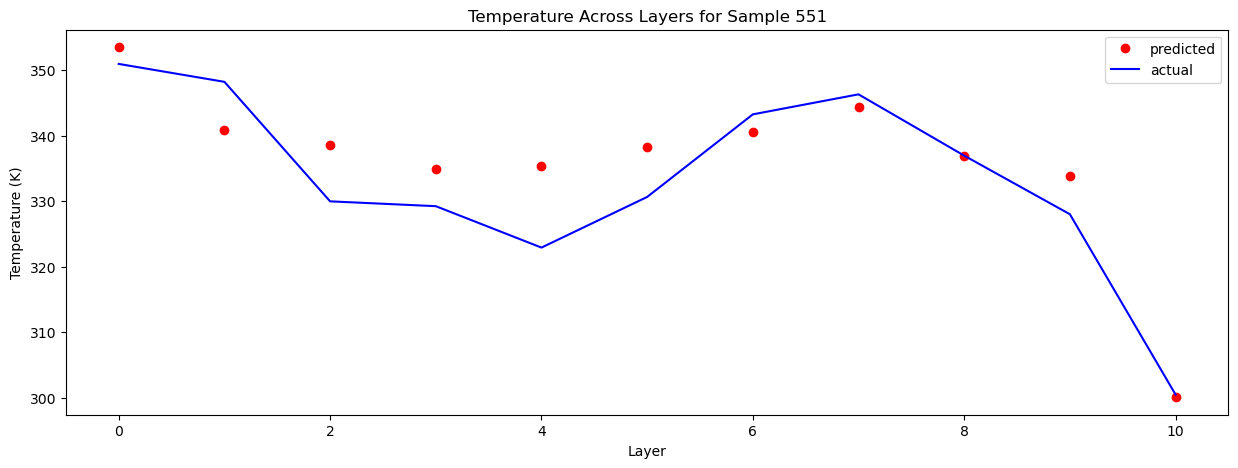

In [899]:
# plot spectrum --> temperature error
import random
num_graphs = 10
indices = []

with torch.no_grad():
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)
